# Amazon-Fine-Food-Review Practical Notebook

I am using amazon find food review 
all data in one sqlite database 

In [1]:
#import all we needed module
import numpy as np
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import model_selection
#from sklearn import cross_validation******** this is not working
from collections import Counter

First we will read data and calculate number of data 

In [2]:
con = sqlite3.connect('amazon/database.sqlite')

# we neglect the review having a score = 3

filtered_data = pd.read_sql_query('''select *from reviews where Score !=3''',con)

def partition(x):
    if x<3 :
        return 'negative'
    return 'positive'
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [3]:
filtered_data.shape

(525814, 10)

In [4]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
filtered_data['Score'].value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

# Exploratory Data Analysis(EDA)

in a eda we clean a data and remove depulication 

In [6]:
display = pd.read_sql_query('''select * from reviews where Score != 3 and userId = "AR5J8UI46CURR" order by ProductID''',con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


Conclusion:-above the table userid, profilrname,time,summary  are given.here we observed that userid,name are same so we remove all duplicates using of a eda.

In [7]:
# we sorting a data according to productid in ascending order

sorted_data = filtered_data.sort_values('ProductId',axis = 0,ascending=True,inplace = False,kind='quicksort',na_position='last')

In [8]:
final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'})
final.shape

(364173, 10)

In [9]:
# After removing duplication , we will see how much %of data still remaing

(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [10]:
display = pd.read_sql_query('''select * from reviews where Score != 3 and Id = 44737 or Id= 64422 order by ProductId ''',con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
#we remove duplication using HelpfulnessDenominator and HelpfulnessNumerator.

final = final[final.HelpfulnessNumerator<= final.HelpfulnessDenominator]

In [12]:
final.shape

(364171, 10)

In [13]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

Now, we do preprocessing like removal of stop words, html tags and make all letters in lowercase.

In [14]:
import re 

i = 0
for sent in final['Text'].values:
    if(len(re.findall('<.>*?',sent))):
        print(i)
        print(sent)
        break;
    i+=1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [15]:
import string
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') # initialising snowball stemmer

def cleanhtml(sentence): #function to clean word of any html tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr , ' ',sentence)
    return cleantext

def cleanpunc(sentence): #function to clean word of any punctuation or special character
    cleaned = re.sub(r'[?|!|\,|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r'',cleaned)
    return cleaned
print(stop)
print('***********************************************')
print(sno.stem('tasty'))

{"mightn't", "won't", 'y', 'shouldn', 'too', 'ain', 'very', 'further', 're', 'most', 'this', 'other', 'just', 'hadn', 'theirs', 'in', 'because', 'up', 'didn', "shouldn't", "you'll", 'how', 'those', 'doesn', 'mightn', 'won', 'd', 'had', 'when', 'with', "wouldn't", 'myself', "isn't", 'for', 'no', 'ourselves', 'nor', "it's", 'they', 'mustn', 'to', 'below', 'them', "wasn't", 'll', "that'll", 'did', 'yourselves', 'at', "you're", 'by', 'an', 'from', "mustn't", 'm', 'if', 'having', 'once', 'me', 'our', 'was', 'isn', 'hers', 'their', "she's", 'can', 'as', 'such', 'herself', 'himself', 'or', 'through', 'whom', 'of', "couldn't", 'her', "haven't", "you'd", 'during', 've', 'ours', 'but', 'haven', 'has', 'your', 'be', 'again', 'only', 'am', 'it', 'should', 'there', "aren't", 'and', "weren't", 'under', 'yours', 'before', 'over', 'these', 'than', 'here', 'on', 'i', 'into', 'any', "hadn't", 'ma', 'being', 'out', 'where', 'wouldn', "shan't", 'shan', "needn't", 'themselves', 'who', 'his', 'not', "hasn't

In [16]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.

i = 0
strl = ' '
final_string  = []
all_positive_words=[] # store words from +ve reviews here
all_negattive_words=[]#store words from -ve reviews here
s= ''

for sent in final['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent) #remove html tag
    
    for w in sent.split():
        for cleaned_word in cleanpunc(w).split():
            if((cleaned_word.isalpha()) & (len(cleaned_word)>2)):
                if(cleaned_word.lower() not in stop):
                    s = (sno.stem(cleaned_word.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if(final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s) #list of all words use to store +ve list 
                    if (final['Score'].values)[i] == 'negative':
                        all_negattive_words.append(s) #list of all words use to store -Ve list
                else:
                    continue
            else:
                continue
                
    #print filtered sentens 
    strl = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(strl)
    i+=1

In [17]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [18]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('finalassignment.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [16]:
import sqlite3
con = sqlite3.connect('finalassignment.sqlite')

In [17]:
cleaned_data = pd.read_sql_query('select * from Reviews', con)

In [18]:
cleaned_data.shape

(364171, 12)

In [19]:
cleaned_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [20]:
cleaned_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [21]:
# To randomly sample 5k points from both class

data_p = cleaned_data[cleaned_data['Score'] == 'positive'].sample(n = 5000)
data_n = cleaned_data[cleaned_data['Score'] == 'negative'].sample(n = 5000)
final_10k = pd.concat([data_p, data_n])
final_10k.shape

(10000, 12)

In [22]:
# Sorting data based on time
final_10k['Time'] = pd.to_datetime(final_10k['Time'], unit = 's')
final_10k = final_10k.sort_values(by = 'Time')

In [23]:
final_10k.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
259,346113,374419,B00004CI84,ADIDQRLLR4KBQ,"""paradise_found""",2,2,positive,2002-03-08,Because My Middle Name is &quot;Weird&quot;,"Set in a small New England town, Tim Burton's ...",b'set small new england town tim masterpiec fo...
309,346029,374331,B00004CI84,A1OP3SQP78M1PP,James Gowen,0,0,positive,2002-03-10,"A movie to ""literally die for!!!""",Beetlejuice is not a movie that you can't watc...,b'beetlejuic movi watch time one funiest movi ...
365,346040,374342,B00004CI84,A10L8O1ZMUIMR2,G. Kleinschmidt,61,79,negative,2002-12-27,Great movie turned bad,"Just to let you know, this movie is one of my ...",b'let know movi one person favorit ghost movi ...
3425,288537,312523,B0000D9N7E,A29LCTLLOPKGX,Karen Chrismer Clark,1,2,positive,2003-11-28,I eat it every day!,We live in the Auvergne region of France and t...,b'live auvergn region franc fantast chees perf...
4419,199024,215708,B0000DHWZH,A1IU7S4HCK1XK0,Joanna Daneman,4,4,positive,2003-12-29,Two uses for this product,1. You can make low carb pancakes with wheat g...,b'make low carb pancak wheat gluten add soy fl...


# Bag Of Word (BOW)

In [80]:
#function to compute the k value


def k_classifier_brute(X_train , y_train):
    
    #creatting odd list of k for knn
    myList = list(range(0,40))
    neighbors = list(filter(lambda x:x%2!=0 , myList))
    
    #empty list that will hold cv score
    cv_scores = []
    
    #perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors = k , algorithm = "brute")
        scores = cross_val_score(knn , X_train , y_train , cv = 10 , scoring = 'accuracy')
        cv_scores.append(scores.mean())
        
    #changing to misclassification error
    MSE = [1 - x for x in cv_scores]
    
    #determinning best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d' % optimal_k)
    
    #plot misclassification error vs k
    plt.plot(neighbors , MSE)
    
    
    for xy in zip(neighbors , np.round(MSE,3)):
        plt.annotate('(%s , %s)' %xy , xy=xy , textcoords = 'data')
    plt.title("Misclassification Error Vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()
    
    print('the misclassification error for each k value is : ' , np.round(MSE,3))
    return optimal_k

In [81]:
#7k data which will use to train model after vectorization

X = final_10k['CleanedText']
print('shape of X :' , X.shape)

shape of X : (10000,)


In [82]:
y = final_10k['Score']
print('shape of y :' , y.shape)

shape of y : (10000,)


In [83]:
# spliting data into 70% as a train and 30% as test data

from sklearn.model_selection import train_test_split
X_train , x_test , y_train , y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape,y_train.shape, x_test.shape, y_test.shape)

(7000,) (7000,) (3000,) (3000,)


In [84]:
#train vectorizor

from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<7000x12540 sparse matrix of type '<class 'numpy.int64'>'
	with 216089 stored elements in Compressed Sparse Row format>

In [85]:
X_train.shape

(7000, 12540)

In [86]:
#Test vectorizor

x_test = bow.transform(x_test)

In [87]:
x_test.shape

(3000, 12540)


The optimal number of neighbors is 35


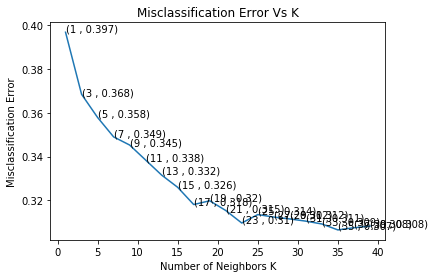

the misclassification error for each k value is :  [0.397 0.368 0.358 0.349 0.345 0.338 0.332 0.326 0.318 0.32  0.315 0.31
 0.314 0.312 0.312 0.311 0.309 0.307 0.308 0.308]


35

In [88]:
# to choss optimal k using brute force algorithm

from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection

#from sklearn import cross_validation not woeking

optimal_k_bow = k_classifier_brute(X_train, y_train)
optimal_k_bow

In [89]:
# instantiate learning model k  = optimal k
knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k_bow)

#fitting the model
knn_optimal.fit (X_train , y_train)

#predict the response
pred = knn_optimal.predict(x_test)

In [90]:
# accurary on train data 

train_acc_bow = knn_optimal.score(X_train , y_train)
print('Train Accuracy :' ,train_acc_bow)
print('Train Accuracy : %f%%' % (train_acc_bow)) # this is accuracy in %age

Train Accuracy : 0.7358571428571429
Train Accuracy : 0.735857%


In [91]:
# error on train data 

train_err_bow = 1-train_acc_bow
print('Train Error: %f%%' % (train_err_bow) )

Train Error: 0.264143%


In [92]:
# evaluate accuracy on test data 
acc_bow = accuracy_score(y_test , pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_bow,acc_bow))


The accuracy of the knn classifier for k = 35 is 69.000000%


In [93]:
# Confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test , pred)
cm

array([[1020,  449],
       [ 481, 1050]], dtype=int64)

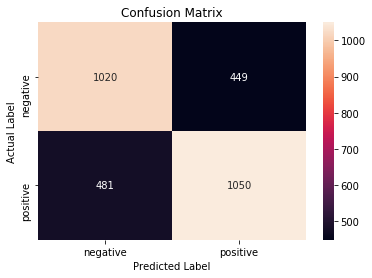

In [94]:
# plot confusion matrix to discribe the performance of classifier.

import seaborn as sns

class_label = ['negative' , 'positive']
df_cm = pd.DataFrame(cm, index = class_label , columns = class_label)
sns.heatmap(df_cm , annot = True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [95]:
# to show main classification report

from sklearn.metrics import classification_report
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

    negative       0.68      0.69      0.69      1469
    positive       0.70      0.69      0.69      1531

    accuracy                           0.69      3000
   macro avg       0.69      0.69      0.69      3000
weighted avg       0.69      0.69      0.69      3000



In [96]:
# model for knn with bag of word
models = pd.DataFrame({'Model': ['KNN with Bow'], 'Hyper Parameter(K)': [optimal_k_bow], 'Train Error': [train_err_bow], 'Test Error': [100-acc_bow], 'Accuracy': [acc_bow ]}, columns = ["Model", "Hyper Parameter(K)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(K),Train Error,Test Error,Accuracy
0,KNN with Bow,35,0.264143,31.0,69.0


Observations:

From above figure(misclassification error vs optimal k, it is showing that classification error for each value of k, when k is increaseing the error is decreasing. For example, if k = 1, error is 36%, k = 2, error is 35% and so on. As I tested our model on unseen data(test data) the accuracy is 68.866 when k = 37

# TF - IDF

In [97]:
# data

X = final_10k['CleanedText']
X.shape

(10000,)

In [98]:
# traget / class label

y = final_10k['Score']
y.shape


(10000,)

In [99]:
#split data

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape,y_train.shape, x_test.shape, y_test.shape)

(7000,) (7000,) (3000,) (3000,)


In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<7000x180794 sparse matrix of type '<class 'numpy.float64'>'
	with 468230 stored elements in Compressed Sparse Row format>

In [101]:
# convert test text data to its vectorizer

x_test = tf_idf_vect.transform(x_test)
x_test.shape

(3000, 180794)


The optimal number of neighbors is 39


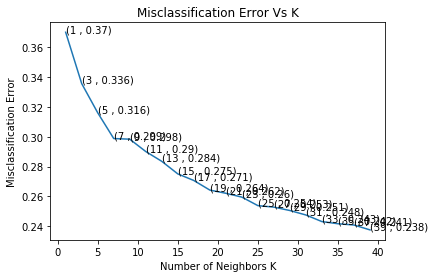

the misclassification error for each k value is :  [0.37  0.336 0.316 0.299 0.298 0.29  0.284 0.275 0.271 0.264 0.262 0.26
 0.254 0.253 0.251 0.248 0.243 0.242 0.241 0.238]


39

In [102]:
# to chossing optimal k

from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection

optimal_k_tfidf = k_classifier_brute(X_train, y_train)
optimal_k_tfidf

In [103]:
# instantiate learning model k = optimal k
knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k_tfidf)

#fitting the model
knn_optimal.fit(X_train , y_train)

#predict the response
pred = knn_optimal.predict(x_test)

In [104]:
#Accuracy of train data

train_acc_tfidf = knn_optimal.score(X_train , y_train)
print('train accuracy :' , train_acc_tfidf)
print('train accuracy : %f%%' % train_acc_tfidf)

train accuracy : 0.788
train accuracy : 0.788000%


In [105]:
# error in train data
train_err_tfidf = 1 - train_acc_tfidf 
print('train accuracy :' , train_err_tfidf)
print('train accuracy : %f%%' % train_err_tfidf)

train accuracy : 0.21199999999999997
train accuracy : 0.212000%


In [106]:
# eveluate accuracy

acc_tfidf = accuracy_score(y_test , pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tfidf,acc_tfidf))


The accuracy of the knn classifier for k = 39 is 75.500000%


In [107]:
# Confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test , pred)
cm

array([[1094,  375],
       [ 360, 1171]], dtype=int64)

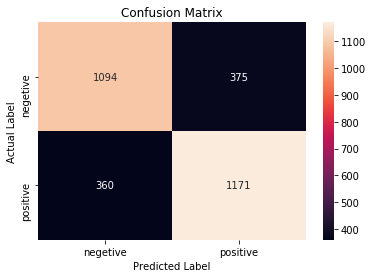

In [108]:
import seaborn as sns
class_label = ['negetive' , 'positive']
df_cm = pd.DataFrame(cm , index = class_label , columns = class_label)
sns.heatmap(df_cm , annot = True , fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [109]:
from sklearn.metrics import classification_report
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

    negative       0.75      0.74      0.75      1469
    positive       0.76      0.76      0.76      1531

    accuracy                           0.76      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.76      0.75      3000



In [110]:
# model for knn with tfidf
models = pd.DataFrame({'Model': ['KNN with TfIdf'], 'Hyper Parameter(K)': [optimal_k_tfidf], 'Train Error': [train_err_tfidf], 'Test Error': [100-acc_tfidf], 'Accuracy': [acc_tfidf ]}, columns = ["Model", "Hyper Parameter(K)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(K),Train Error,Test Error,Accuracy
0,KNN with TfIdf,39,0.212,24.5,75.5


Observations: 
Optimal k is 37 
From Confusion matrix, model predicted 1600 as positive & acutal postive are 1517 and predicted 1400 as negative & actual negative are 1483 which is quite good.
So we can say that, this model works well

# W2V

In [111]:
# data 
X = final_10k['Text']
X.shape

(10000,)

In [112]:
# target / class label 
y = final_10k['Score']
y.shape

(10000,)

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
X_train, x_test, y_train, y_test =train_test_split(X, y, test_size = 0.3)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [114]:
import re

def cleanhtml(sentence): # function to clean the word of any html tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr , ' ' , sentence)
    return cleantext

def cleanpunc(sentence): # function to clean the word of any puntuation or special characters
    cleaned = re.sub(r'[?|!|\'|#]' , r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]' , r'' , sentence)
    return cleaned

In [115]:
# train  your own w2v model using your own train text corpus

import gensim
list_of_sent = []
for sent in X_train:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)

In [116]:
w2v_model = gensim.models.Word2Vec(list_of_sent , min_count = 5 , size = 50 , workers = 4)

In [117]:
w2v_model.wv.most_similar('like')

[('prefer', 0.7811362743377686),
 ('crave', 0.7224477529525757),
 ('flavored', 0.7195355892181396),
 ('smell', 0.7126165628433228),
 ('bland', 0.7122888565063477),
 ('bitter', 0.7046190500259399),
 ('taste', 0.7017338871955872),
 ('sweet', 0.6961236000061035),
 ('tasted', 0.6923169493675232),
 ('though', 0.6877168416976929)]

In [118]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\Users\ACER\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [119]:
w2v.shape

(5126, 50)

In [120]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [121]:
w2v_model=gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

In [122]:
w2v_model.wv.most_similar('like')

[('does', 0.9570172429084778),
 ('really', 0.9544703960418701),
 ('but', 0.9528591632843018),
 ('tastes', 0.9526823163032532),
 ('as', 0.9496139883995056),
 ('good', 0.9380359649658203),
 ('taste', 0.9307497143745422),
 ('just', 0.9287667870521545),
 ('subjective', 0.9260400533676147),
 ('bad', 0.9226056933403015)]

In [123]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\Users\ACER\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [124]:
w2v.shape

(3114, 50)

# Avg w2v 

In [127]:
# average Word2Vec for train data set.....
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence and this is for train data set...
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

7000
50


In [128]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

3000
50


In [129]:
X_train = sent_vectors


In [130]:
x_test = sent_vectors_test


The optimal number of neighbors is 37


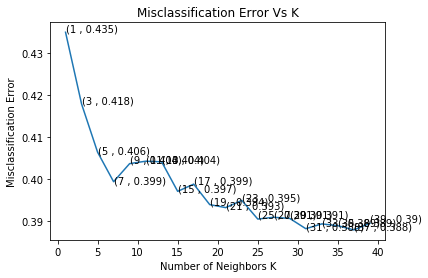

the misclassification error for each k value is :  [0.435 0.418 0.406 0.399 0.404 0.404 0.404 0.397 0.399 0.394 0.393 0.395
 0.391 0.391 0.391 0.388 0.389 0.389 0.388 0.39 ]


37

In [131]:
optimal_k_avgw2v = k_classifier_brute(X_train , y_train)
optimal_k_avgw2v

In [132]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_avgw2v)

# fitting the model
knn_optimal.fit(X_train, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)

In [133]:
# Accuracy on train data
train_acc_avgw2v = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_avgw2v)

Train accuracy 0.6451428571428571


In [134]:
# Error on train data
train_err_avgw2v = 1-train_acc_avgw2v
print("Train Error %f%%" % (train_err_avgw2v))

Train Error 0.354857%


In [135]:
# evaluate accuracy
acc_avg_w2v = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_avgw2v, acc_avg_w2v))


The accuracy of the knn classifier for k = 37 is 62.200000%


In [136]:
print("Test Error %f%%" %(100-(acc_avg_w2v)))

Test Error 37.800000%


In [137]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[987, 551],
       [583, 879]], dtype=int64)

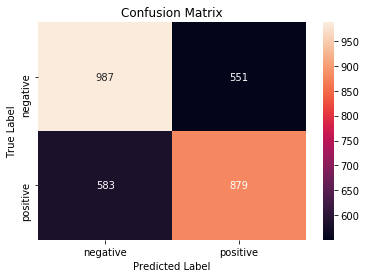

In [138]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [139]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.63      0.64      0.64      1538
    positive       0.61      0.60      0.61      1462

    accuracy                           0.62      3000
   macro avg       0.62      0.62      0.62      3000
weighted avg       0.62      0.62      0.62      3000



In [140]:
# model for knn with tfidf
models = pd.DataFrame({'Model': ['KNN with average Word2Vec'], 'Hyper Parameter(K)': [optimal_k_avgw2v], 'Train Error': [train_err_avgw2v], 'Test Error': [100-acc_avg_w2v], 'Accuracy': [acc_avg_w2v ]}, columns = ["Model", "Hyper Parameter(K)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(K),Train Error,Test Error,Accuracy
0,KNN with average Word2Vec,37,0.354857,37.8,62.2


Observations: 1) Optimal k is 39 2) Accuarcy if model is 60%

# Tf-idf avg2vec

In [141]:
# TF-IDF weighted Word2Vec train dataset
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

C:\Users\ACER\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [142]:
len(tfidf_sent_vectors)


7000

In [143]:
X_train = tfidf_sent_vectors

In [144]:
# tf idf  weigthed word2vec test dataset

tfidf_feat = tf_idf_vect.get_feature_names() #tfidf words / col name

#final tf idf is the sparse matrix with row = sentence col=word and cell val = tfidf

tfidf_sent_vectors_test = [] #the tfdif w2v row = sentence review is stored in the list

row = 0

for sent in  list_of_sent_test: #for each review or sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            # obtain the tf idf of a word in sentence / review
            tfidf = final_tf_idf[row , tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

C:\Users\ACER\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [145]:
len(tfidf_sent_vectors_test)

3000

In [146]:
x_test = tfidf_sent_vectors_test

In [147]:
X_train = np.nan_to_num(X_train)
x_test = np.nan_to_num(x_test)


The optimal number of neighbors is 1


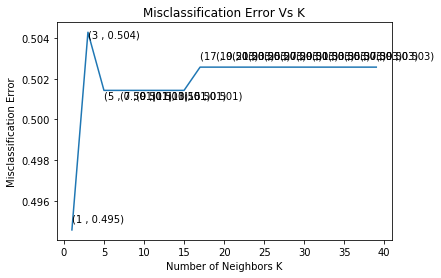

the misclassification error for each k value is :  [0.495 0.504 0.501 0.501 0.501 0.501 0.501 0.501 0.503 0.503 0.503 0.503
 0.503 0.503 0.503 0.503 0.503 0.503 0.503 0.503]


1

In [148]:
optimal_k_tfidf_w2v = k_classifier_brute(X_train , y_train)
optimal_k_tfidf_w2v

In [149]:
# instantiate Learning model k = optimal k 
knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k_tfidf_w2v)

#fitting the model
knn_optimal.fit(X_train , y_train)

#predict the response 
pred = knn_optimal.predict(x_test)

In [150]:
# accuracy on train data

train_acc_tfidf_w2v = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_tfidf_w2v)

Train accuracy 0.49457142857142855


In [151]:
# Error on train data
train_err_tfidf_w2v = 1-train_acc_tfidf_w2v
print("Train Error %f%%" % (train_err_tfidf_w2v))

Train Error 0.505429%


In [152]:
# evaluate accuracy
acc_tfidf_w2v = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tfidf_w2v, acc_tfidf_w2v))


The accuracy of the knn classifier for k = 1 is 51.266667%


In [153]:
print("Test Error %f%%" %(100-(acc_tfidf_w2v)))

Test Error 48.733333%


In [154]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[1538,    0],
       [1462,    0]], dtype=int64)

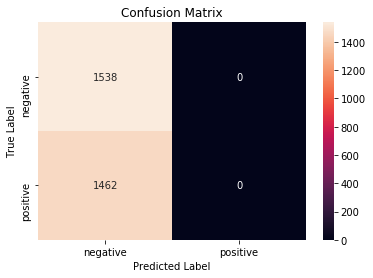

In [155]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [156]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.51      1.00      0.68      1538
    positive       0.00      0.00      0.00      1462

    accuracy                           0.51      3000
   macro avg       0.26      0.50      0.34      3000
weighted avg       0.26      0.51      0.35      3000



C:\Users\ACER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [158]:
# model for knn with tfidf
models = pd.DataFrame({'Model': ['KNN with Tfidf Word2Vec'], 'Hyper Parameter(K)': [optimal_k_tfidf_w2v], 'Train Error': [train_err_tfidf_w2v], 'Test Error': [100-acc_tfidf_w2v], 'Accuracy': [acc_tfidf_w2v ]}, columns = ["Model", "Hyper Parameter(K)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(K),Train Error,Test Error,Accuracy
0,KNN with Tfidf Word2Vec,1,0.505429,48.733333,51.266667


In [159]:
# model
models = pd.DataFrame({'Model': ['KNN with Bow', "KNN with TFIDF", "KNN with Average Word2Vec", "KNN with Tfidf Word2Vec "], 'Hyper Parameter(K)': [optimal_k_bow, optimal_k_tfidf, optimal_k_avgw2v, optimal_k_tfidf_w2v], 'Train Error': [train_err_bow, train_err_tfidf, train_err_avgw2v, train_err_tfidf_w2v], 'Test Error': [100-acc_bow, 100-acc_tfidf, 100-acc_avg_w2v, 100-acc_tfidf_w2v], 'Accuracy': [acc_bow, acc_tfidf, acc_avg_w2v, acc_tfidf_w2v]}, columns = ["Model", "Hyper Parameter(K)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(K),Train Error,Test Error,Accuracy
1,KNN with TFIDF,39,0.212000,24.500000,75.500000
0,KNN with Bow,35,0.264143,31.000000,69.000000
2,KNN with Average Word2Vec,37,0.354857,37.800000,62.200000
3,KNN with Tfidf Word2Vec,1,0.505429,48.733333,51.266667


Conclusion: As per above table, it is cleared that KNN with tf-IDF is quite good.